## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.preprocessing as skpre
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time

import DataProcessor
import SRMSE
import VAE

## Choose Variables and Preprocess

In [2]:
# Load in the persons PUMS dataset for WA state
p_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_p53.csv")
h_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_h53.csv")

# Filter to desired variables (numeric then categorical)
pums_data_h = h_df[['SERIALNO','HINCP','NP','VEH','BLD','ACCESS']]
pums_data_p = p_df[['SERIALNO','PWGTP','PINCP','AGEP','JWMNP','SEX','SCHL','MAR','COW','DPHY','DEYE','DREM','RAC1P']]
del h_df
del p_df
pums_data = pd.merge(pums_data_p, pums_data_h, on='SERIALNO')
pums_data = pums_data.drop(labels=['SERIALNO'], axis=1)

# Convert numerical variables to categorical bins
pums_data['HINCP'], hincp_bins = pd.qcut(pums_data['HINCP'], q=10, labels=False, retbins=True)
pums_data['AGEP'], agep_bins = pd.qcut(pums_data['AGEP'], q=10, labels=False, retbins=True)
pums_data['JWMNP'], jwmnp_bins = pd.qcut(pums_data['JWMNP'], q=10, labels=False, retbins=True)
pums_data['PINCP'], pincp_bins = pd.qcut(pums_data['PINCP'], q=10, labels=False, retbins=True)


# Remove NA values and check n before/after
print(f"Dataset n={len(pums_data)} pre-cleaning")
pums_data = pums_data.dropna()
print(f"Dataset n={len(pums_data)} post-cleaning")

# Scale by the person-weights to get true population
pums_data = pums_data.reindex(pums_data.index.repeat(pums_data['PWGTP']))
pums_data = pums_data.drop('PWGTP', axis=1)
pums_data_p = pums_data_p.drop('PWGTP', axis=1)
np.random.seed(420)
pums_data = pums_data.sample(150000)
pums_data

Dataset n=359075 pre-cleaning
Dataset n=150203 post-cleaning


,PINCP,AGEP,JWMNP,SEX,SCHL,MAR,COW,DPHY,DEYE,DREM,RAC1P,HINCP,NP,VEH,BLD,ACCESS
124097,8.0,4,4.0,1,20.0,5,2.0,2.0,2,2.0,1,5.0,1,1.0,2.0,1.0
213970,6.0,7,2.0,1,18.0,3,1.0,2.0,2,2.0,1,2.0,2,3.0,1.0,1.0
244109,9.0,5,4.0,1,21.0,1,1.0,2.0,2,2.0,1,7.0,4,2.0,2.0,1.0
203719,8.0,5,9.0,2,21.0,2,2.0,2.0,2,2.0,9,4.0,1,1.0,3.0,1.0
118501,1.0,6,5.0,2,15.0,2,2.0,2.0,2,2.0,1,0.0,1,2.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145574,6.0,2,1.0,1,21.0,1,1.0,2.0,2,2.0,1,5.0,2,2.0,7.0,1.0
141400,3.0,3,2.0,2,16.0,5,1.0,2.0,2,2.0,3,0.0,3,1.0,2.0,1.0
180818,5.0,6,1.0,2,16.0,3,2.0,2.0,2,2.0,2,1.0,1,2.0,6.0,2.0
354161,7.0,4,0.0,1,16.0,1,1.0,2.0,2,2.0,1,7.0,3,4.0,2.0,1.0


In [3]:
HH_IDX = pums_data_p.shape[1] - 1  # Index of household variables start
VAR_DIM = pums_data.shape[1]  # Length of all variables before OHE
VAR_NAMES = pums_data.columns  # Names of all variables before OHE
HH_VAR_NAMES = pums_data_h.columns  # Names of the hh variables

del pums_data_p
del pums_data_h

# Split categorical data into OHE vars, save num classes per variable, as well as numeric encodings per variable
dummies_list = []
pums_encodings_list = []
for x in range(VAR_DIM):
    dummies = pums_data.iloc[:,x]
    pums_encodings_list.append(np.unique(dummies.values))
    dummies = pd.get_dummies(dummies, prefix=f"{pums_data.columns[x]}_")
    dummies_list.append(dummies)
    del dummies
CAT_LENGTHS = [x.shape[1] for x in dummies_list]
print(f"Categorical variable class lengths: {CAT_LENGTHS}")

Categorical variable class lengths: [10, 9, 10, 2, 24, 5, 8, 2, 2, 2, 9, 10, 18, 7, 10, 3]


In [4]:
# Final data frame after encoding OHE
model_data_df = pd.DataFrame()
for ohe_var in dummies_list:
    model_data_df = pd.concat([model_data_df, ohe_var], axis=1)
del ohe_var
MANIFEST_DIM = model_data_df.shape[1]
HH_IDX_MANIFEST = sum(CAT_LENGTHS[:HH_IDX])

# Add columns for original household variables; these will be used as conditionals
model_data_df = pd.concat([model_data_df, model_data_df.iloc[:,HH_IDX_MANIFEST:]], axis=1)

# Preview data that will be fed into model
model_data_df

,PINCP__0.0,PINCP__1.0,PINCP__2.0,PINCP__3.0,PINCP__4.0,PINCP__5.0,PINCP__6.0,PINCP__7.0,PINCP__8.0,PINCP__9.0,...,BLD__4.0,BLD__5.0,BLD__6.0,BLD__7.0,BLD__8.0,BLD__9.0,BLD__10.0,ACCESS__1.0,ACCESS__2.0,ACCESS__3.0
124097,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
213970,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
244109,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
203719,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
118501,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145574,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
141400,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
180818,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
354161,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
# Separate into train/test data
model_data = model_data_df.values
train_idx = round(len(model_data)*.7)
train_data = model_data[0:train_idx,:]
test_data = model_data[train_idx:len(model_data),:]

print(f"Training on {train_idx} samples")

Training on 105000 samples


## Set Parameters and Define Model

In [6]:
# Grid Search SRMSE 1
# BATCH_SIZES = [64, 128, 256, 512, 1024]
# EPOCHS = [1000]
# LATENT_DIMS = [4, 6, 8]
# HIDDEN_DIMS = [8, 16, 32, 64]
# KL_WEIGHTS = [.01, .05, .1, 1.0]
# [313.08608531951904, 11.0505690574646, 0.02598349649036663, 0.006970305382407434, [512, 1000, 6, 64, 0.1]]
# [290.68157863616943, 6.595394611358643, 0.026173123522601732, 0.00692727365319053, [256, 1000, 6, 64, 0.1]]
# [99.60163021087646, 6.652237892150879, 0.028944710845045213, 0.0071278053533916155, [1024, 1000, 8, 16, 0.05]]

# Hyperparameters
BATCH_SIZE = 1024
EPOCHS = 1000
LATENT_DIM = 8
HIDDEN_DIM = 16
KL_WEIGHT = .05

## Training

In [7]:
val_loss = []
val_epochs = []
class validationCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            val_epochs.append(epoch)
            # Use random sample of 1000 from test data to validate the model
            idx = np.random.randint(test_data.shape[0], size=1000)
            val_data = test_data[idx]
            results = vae.predict(val_data)
            loss_cat = VAE.get_reconstruction_loss(val_data, results, CAT_LENGTHS)
            val_loss.append(loss_cat)

In [8]:
# # Load in the synthetic households
# synth_hh_df = pd.read_csv('data/synthetic_populations/wa_households.csv')
# synth_hh_ohe_df = pd.read_csv('data/synthetic_populations/wa_households_raw.csv')

# # Multiply the inputs by the number of persons per household (hh of size 3 becomes 3 rows with same scaled hh inputs)
# synth_hh_df['HH_ID'] = synth_hh_df.index
# synth_hh_ohe_df = synth_hh_ohe_df.reindex(synth_hh_ohe_df.index.repeat(synth_hh_df['NP']))
# synth_hh_df = synth_hh_df.reindex(synth_hh_df.index.repeat(synth_hh_df['NP']))

def testModel(test_vae, latent_dim):
    # How many synthetic households to fill
    POP_SIZE = len(synth_hh_ohe_df)

    # Generate random normal sample to represent each latent variable, for each row (different person per row)
    np.random.seed(42)
    epsilon = np.random.normal(loc=0, scale=1, size=(POP_SIZE, latent_dim))

    start_time = time.time()
    # Generate persons; each person has unique latent input, plus shared hh inputs with their household
    results = vae.decoder.predict([epsilon, synth_hh_ohe_df.values])
    gen_time = time.time() - start_time

    # Convert the test results from logits to values
    synth_p_df = pd.DataFrame()
    for i, x in enumerate(results[0]):
        result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
        result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
        synth_p_df = pd.concat([synth_p_df, result_df], axis=1)
    synth_p_df.columns = VAR_NAMES

    # Assign the control variables from the synthetic households to individuals (replace what came from the model)
    for var in HH_VAR_NAMES[1:]:
        synth_p_df[f"{var}"] = synth_hh_df[f"{var}"].values

    srmse_uni = SRMSE.calculateSRMSE(synth_p_df, pums_data.sample(POP_SIZE, replace=True, random_state=42))
    srmse_bi = SRMSE.calculateBivariateSRMSE(synth_p_df, pums_data.sample(POP_SIZE, replace=True, random_state=42))

    return gen_time, srmse_uni, srmse_bi

In [9]:
# # Use grid search to train model and get results for many different hyperparameters
# grid_search_results = []
# for bs in BATCH_SIZES:
#     for e in EPOCHS:
#         for ld in LATENT_DIMS:
#             for hd in HIDDEN_DIMS:
#                 for klw in KL_WEIGHTS:
#                     print(f"[{bs}, {e}, {ld}, {hd}, {klw}]")
#                     start_time = time.time()
#                     vae = VAE.VAE(MANIFEST_DIM, hd, ld, CAT_LENGTHS, HH_IDX, klw)
#                     vae.compile(optimizer=keras.optimizers.Adam())
#                     history = vae.fit(train_data, epochs=e, batch_size=bs, callbacks=[validationCallback()], verbose=0)
#                     train_time = (time.time()-start_time)
#                     gen_time, srmse_uni, srmse_bi = testModel(test_vae=vae, latent_dim=ld)
#                     results = [train_time, gen_time, srmse_uni, srmse_bi, [bs,e,ld,hd,klw]]
#                     grid_search_results.append(results)

# # Find the best results for each metric in the grid search
# min_srmse_uni_idx = 0
# min_srmse_uni_value = 999999999
# min_srmse_bi_idx = 0
# min_srmse_bi_value = 999999999
# min_eff_idx = 0
# min_eff_value = 999999999
# for i, result in enumerate(grid_search_results):
#     tot_time = result[0]+result[1]
#     time_eff = (result[2]+result[3] / 2) * tot_time
#     if result[2] < min_srmse_uni_value:
#         min_srmse_uni_idx = i
#         min_srmse_uni_value = result[2]
#     if result[3] < min_srmse_bi_value:
#         min_srmse_bi_idx = i
#         min_srmse_bi_value = result[3]
#     if time_eff < min_eff_value:
#         min_eff_idx = i
#         min_eff_value = time_eff

# # Display the results
# print(grid_search_results[min_srmse_uni_idx])
# print(grid_search_results[min_srmse_bi_idx])
# print(grid_search_results[min_eff_idx])

In [10]:
# Train the model using single set of hyperparameters
start_time = time.time()
vae = VAE.VAE(MANIFEST_DIM, HIDDEN_DIM, LATENT_DIM, CAT_LENGTHS, HH_IDX, KL_WEIGHT)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[validationCallback()])
print(f"--- {time.time() - start_time} seconds ---")

Epoch 1/1000
103/103 [==============================] - 1s 10ms/step - tot_loss: 23.8328 - rec_loss: 23.6230 - kl_loss: 0.2098
Epoch 2/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 19.3662 - rec_loss: 19.2135 - kl_loss: 0.1526
Epoch 3/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 17.9859 - rec_loss: 17.8084 - kl_loss: 0.1775
Epoch 4/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 16.7656 - rec_loss: 16.5380 - kl_loss: 0.2276
Epoch 5/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 15.7870 - rec_loss: 15.5157 - kl_loss: 0.2713
Epoch 6/1000
103/103 [==============================] - 2s 16ms/step - tot_loss: 14.9903 - rec_loss: 14.7026 - kl_loss: 0.2877
Epoch 7/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 14.2928 - rec_loss: 13.9932 - kl_loss: 0.2996
Epoch 8/1000
103/103 [==============================] - 1s 14ms/step - tot_loss: 13.6593 - rec_loss: 13.3327 - kl_lo

103/103 [==============================] - 1s 7ms/step - tot_loss: 6.9683 - rec_loss: 6.3607 - kl_loss: 0.6075
Epoch 67/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 6.9356 - rec_loss: 6.3253 - kl_loss: 0.6103
Epoch 68/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 6.9044 - rec_loss: 6.2942 - kl_loss: 0.6103
Epoch 69/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 6.8736 - rec_loss: 6.2613 - kl_loss: 0.6122
Epoch 70/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 6.8446 - rec_loss: 6.2302 - kl_loss: 0.6144
Epoch 71/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 6.8119 - rec_loss: 6.1965 - kl_loss: 0.6154
Epoch 72/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 6.7840 - rec_loss: 6.1668 - kl_loss: 0.6172
Epoch 73/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 6.7557 - rec_loss: 6.1380 - kl_loss: 0.6177
Epoch 74/1000


103/103 [==============================] - 1s 8ms/step - tot_loss: 5.7646 - rec_loss: 5.0975 - kl_loss: 0.6672
Epoch 132/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 5.7537 - rec_loss: 5.0856 - kl_loss: 0.6680
Epoch 133/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 5.7428 - rec_loss: 5.0747 - kl_loss: 0.6681
Epoch 134/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 5.7330 - rec_loss: 5.0642 - kl_loss: 0.6687
Epoch 135/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 5.7229 - rec_loss: 5.0543 - kl_loss: 0.6686
Epoch 136/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 5.7156 - rec_loss: 5.0451 - kl_loss: 0.6704
Epoch 137/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 5.7055 - rec_loss: 5.0343 - kl_loss: 0.6712
Epoch 138/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 5.6936 - rec_loss: 5.0232 - kl_loss: 0.6704
Epoch 1

103/103 [==============================] - 1s 7ms/step - tot_loss: 5.2782 - rec_loss: 4.5864 - kl_loss: 0.6918
Epoch 197/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 5.2731 - rec_loss: 4.5821 - kl_loss: 0.6910
Epoch 198/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 5.2658 - rec_loss: 4.5743 - kl_loss: 0.6915
Epoch 199/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 5.2607 - rec_loss: 4.5684 - kl_loss: 0.6923
Epoch 200/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 5.2558 - rec_loss: 4.5635 - kl_loss: 0.6923
Epoch 201/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 5.2498 - rec_loss: 4.5573 - kl_loss: 0.6925
Epoch 202/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 5.2444 - rec_loss: 4.5525 - kl_loss: 0.6919
Epoch 203/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 5.2406 - rec_loss: 4.5473 - kl_loss: 0.6932
Epoch 2

103/103 [==============================] - 1s 8ms/step - tot_loss: 4.9780 - rec_loss: 4.2747 - kl_loss: 0.7034
Epoch 262/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 4.9739 - rec_loss: 4.2702 - kl_loss: 0.7038
Epoch 263/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 4.9705 - rec_loss: 4.2667 - kl_loss: 0.7038
Epoch 264/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 4.9671 - rec_loss: 4.2629 - kl_loss: 0.7041
Epoch 265/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 4.9633 - rec_loss: 4.2596 - kl_loss: 0.7037
Epoch 266/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 4.9593 - rec_loss: 4.2544 - kl_loss: 0.7049
Epoch 267/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 4.9558 - rec_loss: 4.2509 - kl_loss: 0.7049
Epoch 268/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 4.9518 - rec_loss: 4.2472 - kl_loss: 0.7046
Epoch 2

103/103 [==============================] - 1s 10ms/step - tot_loss: 4.7404 - rec_loss: 4.0242 - kl_loss: 0.7162
Epoch 327/1000
103/103 [==============================] - 1s 10ms/step - tot_loss: 4.7369 - rec_loss: 4.0199 - kl_loss: 0.7170
Epoch 328/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 4.7317 - rec_loss: 4.0153 - kl_loss: 0.7164
Epoch 329/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 4.7263 - rec_loss: 4.0089 - kl_loss: 0.7174
Epoch 330/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 4.7249 - rec_loss: 4.0070 - kl_loss: 0.7180
Epoch 331/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 4.7172 - rec_loss: 3.9987 - kl_loss: 0.7185
Epoch 332/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 4.7131 - rec_loss: 3.9941 - kl_loss: 0.7189
Epoch 333/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 4.7087 - rec_loss: 3.9895 - kl_loss: 0.7192
Epoch

103/103 [==============================] - 1s 10ms/step - tot_loss: 4.3603 - rec_loss: 3.5937 - kl_loss: 0.7665
Epoch 391/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 4.3565 - rec_loss: 3.5901 - kl_loss: 0.7664
Epoch 392/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 4.3514 - rec_loss: 3.5843 - kl_loss: 0.7672
Epoch 393/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 4.3471 - rec_loss: 3.5799 - kl_loss: 0.7672
Epoch 394/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 4.3411 - rec_loss: 3.5735 - kl_loss: 0.7676
Epoch 395/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 4.3398 - rec_loss: 3.5708 - kl_loss: 0.7691
Epoch 396/1000
103/103 [==============================] - 1s 11ms/step - tot_loss: 4.3330 - rec_loss: 3.5642 - kl_loss: 0.7689
Epoch 397/1000
103/103 [==============================] - 1s 9ms/step - tot_loss: 4.3270 - rec_loss: 3.5581 - kl_loss: 0.7690
Epoch

103/103 [==============================] - 1s 7ms/step - tot_loss: 4.1363 - rec_loss: 3.3526 - kl_loss: 0.7836
Epoch 456/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 4.1365 - rec_loss: 3.3527 - kl_loss: 0.7838
Epoch 457/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 4.1344 - rec_loss: 3.3502 - kl_loss: 0.7842
Epoch 458/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 4.1292 - rec_loss: 3.3456 - kl_loss: 0.7837
Epoch 459/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 4.1305 - rec_loss: 3.3453 - kl_loss: 0.7852
Epoch 460/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 4.1257 - rec_loss: 3.3412 - kl_loss: 0.7844
Epoch 461/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 4.1228 - rec_loss: 3.3384 - kl_loss: 0.7844
Epoch 462/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 4.1176 - rec_loss: 3.3335 - kl_loss: 0.7841
Epoch 4

103/103 [==============================] - 1s 8ms/step - tot_loss: 3.9925 - rec_loss: 3.2049 - kl_loss: 0.7875
Epoch 521/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 3.9900 - rec_loss: 3.2019 - kl_loss: 0.7880
Epoch 522/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 3.9888 - rec_loss: 3.2006 - kl_loss: 0.7882
Epoch 523/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 3.9880 - rec_loss: 3.2003 - kl_loss: 0.7877
Epoch 524/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 3.9828 - rec_loss: 3.1955 - kl_loss: 0.7873
Epoch 525/1000
103/103 [==============================] - 1s 9ms/step - tot_loss: 3.9827 - rec_loss: 3.1949 - kl_loss: 0.7878
Epoch 526/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 3.9822 - rec_loss: 3.1933 - kl_loss: 0.7889
Epoch 527/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 3.9802 - rec_loss: 3.1920 - kl_loss: 0.7882
Epoch 5

103/103 [==============================] - 1s 7ms/step - tot_loss: 3.8894 - rec_loss: 3.0978 - kl_loss: 0.7916
Epoch 586/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 3.8865 - rec_loss: 3.0962 - kl_loss: 0.7903
Epoch 587/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 3.8842 - rec_loss: 3.0933 - kl_loss: 0.7908
Epoch 588/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 3.8853 - rec_loss: 3.0938 - kl_loss: 0.7915
Epoch 589/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 3.8829 - rec_loss: 3.0914 - kl_loss: 0.7915
Epoch 590/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 3.8816 - rec_loss: 3.0904 - kl_loss: 0.7913
Epoch 591/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 3.8785 - rec_loss: 3.0876 - kl_loss: 0.7910
Epoch 592/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 3.8762 - rec_loss: 3.0850 - kl_loss: 0.7912
Epoch 5

103/103 [==============================] - 1s 7ms/step - tot_loss: 3.8087 - rec_loss: 3.0147 - kl_loss: 0.7940
Epoch 651/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 3.8066 - rec_loss: 3.0121 - kl_loss: 0.7945
Epoch 652/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 3.8060 - rec_loss: 3.0114 - kl_loss: 0.7946
Epoch 653/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 3.8053 - rec_loss: 3.0109 - kl_loss: 0.7944
Epoch 654/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 3.8020 - rec_loss: 3.0073 - kl_loss: 0.7947
Epoch 655/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 3.8032 - rec_loss: 3.0085 - kl_loss: 0.7947
Epoch 656/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 3.8032 - rec_loss: 3.0078 - kl_loss: 0.7954
Epoch 657/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 3.7996 - rec_loss: 3.0051 - kl_loss: 0.7945
Epoch 6

103/103 [==============================] - 1s 10ms/step - tot_loss: 3.7415 - rec_loss: 2.9443 - kl_loss: 0.7972
Epoch 716/1000
103/103 [==============================] - 1s 9ms/step - tot_loss: 3.7412 - rec_loss: 2.9447 - kl_loss: 0.7965
Epoch 717/1000
103/103 [==============================] - 1s 9ms/step - tot_loss: 3.7397 - rec_loss: 2.9419 - kl_loss: 0.7978
Epoch 718/1000
103/103 [==============================] - 1s 10ms/step - tot_loss: 3.7381 - rec_loss: 2.9408 - kl_loss: 0.7972
Epoch 719/1000
103/103 [==============================] - 1s 10ms/step - tot_loss: 3.7393 - rec_loss: 2.9416 - kl_loss: 0.7978
Epoch 720/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 3.7356 - rec_loss: 2.9382 - kl_loss: 0.7974
Epoch 721/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 3.7362 - rec_loss: 2.9385 - kl_loss: 0.7977
Epoch 722/1000
103/103 [==============================] - 1s 9ms/step - tot_loss: 3.7349 - rec_loss: 2.9376 - kl_loss: 0.7973
Epoc

103/103 [==============================] - 1s 11ms/step - tot_loss: 3.6860 - rec_loss: 2.8867 - kl_loss: 0.7993
Epoch 780/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 3.6860 - rec_loss: 2.8865 - kl_loss: 0.7996
Epoch 781/1000
103/103 [==============================] - 1s 9ms/step - tot_loss: 3.6831 - rec_loss: 2.8832 - kl_loss: 0.7999
Epoch 782/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 3.6849 - rec_loss: 2.8849 - kl_loss: 0.7999
Epoch 783/1000
103/103 [==============================] - 1s 9ms/step - tot_loss: 3.6849 - rec_loss: 2.8843 - kl_loss: 0.8006
Epoch 784/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 3.6869 - rec_loss: 2.8872 - kl_loss: 0.7997
Epoch 785/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 3.6834 - rec_loss: 2.8833 - kl_loss: 0.8000
Epoch 786/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 3.6812 - rec_loss: 2.8809 - kl_loss: 0.8003
Epoch 

103/103 [==============================] - 1s 8ms/step - tot_loss: 3.6380 - rec_loss: 2.8363 - kl_loss: 0.8017
Epoch 845/1000
103/103 [==============================] - 1s 7ms/step - tot_loss: 3.6366 - rec_loss: 2.8352 - kl_loss: 0.8014
Epoch 846/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 3.6402 - rec_loss: 2.8383 - kl_loss: 0.8018
Epoch 847/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 3.6359 - rec_loss: 2.8337 - kl_loss: 0.8023
Epoch 848/1000
103/103 [==============================] - 1s 10ms/step - tot_loss: 3.6355 - rec_loss: 2.8337 - kl_loss: 0.8017
Epoch 849/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 3.6336 - rec_loss: 2.8317 - kl_loss: 0.8020
Epoch 850/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 3.6325 - rec_loss: 2.8305 - kl_loss: 0.8020
Epoch 851/1000
103/103 [==============================] - 1s 9ms/step - tot_loss: 3.6324 - rec_loss: 2.8304 - kl_loss: 0.8020
Epoch 

103/103 [==============================] - 2s 15ms/step - tot_loss: 3.5961 - rec_loss: 2.7925 - kl_loss: 0.8036
Epoch 910/1000
103/103 [==============================] - 2s 16ms/step - tot_loss: 3.5924 - rec_loss: 2.7881 - kl_loss: 0.8043
Epoch 911/1000
103/103 [==============================] - 2s 18ms/step - tot_loss: 3.5965 - rec_loss: 2.7924 - kl_loss: 0.8040
Epoch 912/1000
103/103 [==============================] - 1s 11ms/step - tot_loss: 3.5936 - rec_loss: 2.7894 - kl_loss: 0.8042
Epoch 913/1000
103/103 [==============================] - 1s 10ms/step - tot_loss: 3.5924 - rec_loss: 2.7876 - kl_loss: 0.8048
Epoch 914/1000
103/103 [==============================] - 2s 15ms/step - tot_loss: 3.5923 - rec_loss: 2.7880 - kl_loss: 0.8043
Epoch 915/1000
103/103 [==============================] - 1s 11ms/step - tot_loss: 3.5919 - rec_loss: 2.7876 - kl_loss: 0.8043
Epoch 916/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 3.5899 - rec_loss: 2.7854 - kl_loss: 0.8045


103/103 [==============================] - 1s 9ms/step - tot_loss: 3.5570 - rec_loss: 2.7515 - kl_loss: 0.8055
Epoch 974/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 3.5572 - rec_loss: 2.7514 - kl_loss: 0.8058
Epoch 975/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 3.5573 - rec_loss: 2.7506 - kl_loss: 0.8067
Epoch 976/1000
103/103 [==============================] - 1s 12ms/step - tot_loss: 3.5541 - rec_loss: 2.7482 - kl_loss: 0.8060
Epoch 977/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 3.5564 - rec_loss: 2.7492 - kl_loss: 0.8072
Epoch 978/1000
103/103 [==============================] - 1s 10ms/step - tot_loss: 3.5548 - rec_loss: 2.7482 - kl_loss: 0.8066
Epoch 979/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 3.5558 - rec_loss: 2.7494 - kl_loss: 0.8064
Epoch 980/1000
103/103 [==============================] - 1s 8ms/step - tot_loss: 3.5563 - rec_loss: 2.7495 - kl_loss: 0.8067
Epoch

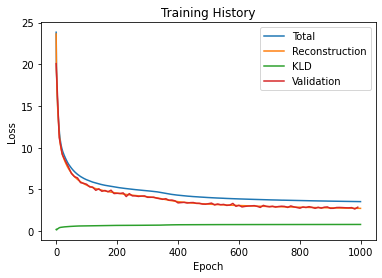

In [11]:
# Plot model loss/training progress
plt.plot(history.history['tot_loss'])
plt.plot(history.history['rec_loss'])
plt.plot(history.history['kl_loss'])
plt.plot(val_epochs, val_loss)
plt.title("Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Total","Reconstruction","KLD","Validation"], loc="upper right")
plt.show()

## Testing

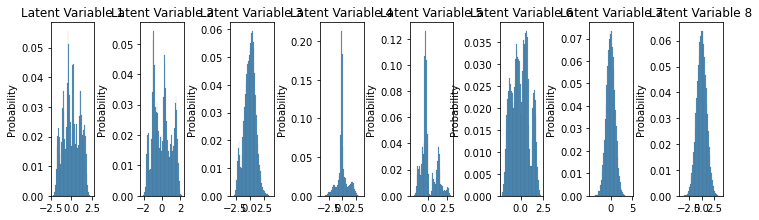

In [12]:
# Get latent vars from the encoder; feed to decoder and get sampled manifest variables
z_mean, z_logvar, z = vae.encoder.predict(test_data[:,:MANIFEST_DIM])

# Show distributions of the resulting variables
fig, axes = plt.subplots(nrows=1, ncols=LATENT_DIM, figsize=(10,3))
fig.tight_layout(w_pad=2, h_pad=10)

for i in range(LATENT_DIM):
    sns.histplot(z[:,i], ax=axes[i], bins=50, stat="probability")
    axes[i].set_title(f"Latent Variable {i+1}")

In [13]:
# Draw predictions from test data
results = vae.predict(test_data)
loss_cat = VAE.get_reconstruction_loss(test_data, results, CAT_LENGTHS)
print(f"Categorical Variable Loss: {loss_cat}")

Categorical Variable Loss: 2.7430567741394043


In [14]:
# Convert the testing data from ohe to values
test_data_df = pd.DataFrame()
for i, x in enumerate(results[0]):
    result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    test_data_df = pd.concat([test_data_df, result_df], axis=1)
test_data_df.columns = VAR_NAMES

# Convert the test results from logits to values
test_results_df = pd.DataFrame()
for i, x in enumerate(results[0]):
    result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    test_results_df = pd.concat([test_results_df, result_df], axis=1)
test_results_df.columns = VAR_NAMES

## Generating Synthetic Population

In [15]:
# Load in the synthetic households
synth_hh_df = pd.read_csv('data/synthetic_populations/wa_households.csv')
synth_hh_ohe_df = pd.read_csv('data/synthetic_populations/wa_households_raw.csv')

# How many variables represent each household
HH_DIM = 5

In [16]:
# Multiply the inputs by the number of persons per household (hh of size 3 becomes 3 rows with same scaled hh inputs)
synth_hh_df['HH_ID'] = synth_hh_df.index
synth_hh_ohe_df = synth_hh_ohe_df.reindex(synth_hh_ohe_df.index.repeat(synth_hh_df['NP']))
synth_hh_df = synth_hh_df.reindex(synth_hh_df.index.repeat(synth_hh_df['NP']))

# How many synthetic households to fill
POP_SIZE = len(synth_hh_ohe_df)
print(POP_SIZE)

268705


In [17]:
# Generate random normal sample to represent each latent variable, for each row (different person per row)
epsilon = np.random.normal(loc=0, scale=1, size=(POP_SIZE, LATENT_DIM))

# Load the most recently trained model
# vae = keras.models.load_model('person_synthesizer')

start_time = time.time()

# Generate persons; each person has unique latent input, plus shared hh inputs with their household
results = vae.decoder.predict([epsilon, synth_hh_ohe_df.values])

print(f"--- {time.time() - start_time} seconds ---")

del epsilon

# Convert the test results from logits to values
synth_p_df = pd.DataFrame()
for i, x in enumerate(results[0]):
    result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    synth_p_df = pd.concat([synth_p_df, result_df], axis=1)
synth_p_df.columns = VAR_NAMES

# Assign the control variables from the synthetic households to individuals (replace what came from the model)
for var in HH_VAR_NAMES[1:]:
    synth_p_df[f"{var}"] = synth_hh_df[f"{var}"].values

# Save the synthesized persons
synth_p_df.to_csv('data/synthetic_populations/wa_persons_100000.csv', index=False)

--- 15.696746349334717 seconds ---


<ipython-input-18-370640e01e01>:3: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout(h_pad=40)


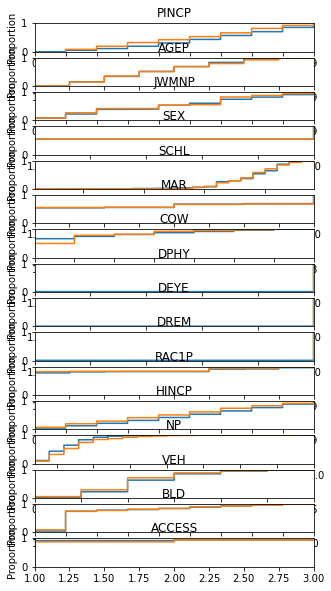

In [18]:
# Generate Distributions of All HH variables
fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=1, figsize=(5,10))
fig.tight_layout(h_pad=40)

for i, var in enumerate(VAR_NAMES):
    sns.ecdfplot(data=pums_data, x=var, ax=axes[i]).set(xlim=(min(pums_data[var]),max(pums_data[var])))
    sns.ecdfplot(data=synth_p_df, x=var, ax=axes[i]).set(xlim=(min(pums_data[var]),max(pums_data[var])))
    axes[i].set_title(var)
    axes[i].set_xlabel(None)

In [19]:
testModel(test_vae=vae, latent_dim=LATENT_DIM)
# gen_time, srmse_uni, srmse_bi

Univariate (marginal) SRMSE: 0.2964504531180633, Total Bins: 131
Bivariate (joint) SRMSE: 0.846157263640871, Total Bins: 7768


(13.81206750869751, 0.2964504531180633, 0.846157263640871)